In [1]:
path_neymar = 'https://raw.githubusercontent.com/LunusMax/football-data/refs/heads/main/Neymar/neymar_progression.csv'
path_players = 'https://raw.githubusercontent.com/LunusMax/football-data/refs/heads/main/Neymar/other_progression.csv'

In [2]:
import pandas as pd

data_neymar = pd.read_csv(path_neymar, sep=';')
data_players = pd.read_csv(path_players, sep=';')

In [3]:
data_neymar.head(7)

,Ano,Time,Min,PrgC,PrgP,PrgR,PrgC_per90,PrgP_per90,prgR_per90,xG,xAG
0,17/18,PSG,1786,152,204,226,7.66,10.28,11.39,0.75,0.57
1,18/19,PSG,1439,125,177,138,7.82,11.07,8.63,0.69,0.43
2,19/20,PSG,1318,110,160,159,7.51,10.93,10.86,1.00,0.39
3,20/21,PSG,1415,103,160,163,6.55,10.18,10.37,0.83,0.46
4,21/22,PSG,1851,96,146,244,4.67,7.10,11.86,0.53,0.37
5,22/23,PSG,1545,69,161,127,4.02,9.38,7.40,0.47,0.51
6,2025,Santos,809,29,68,44,3.23,7.56,4.89,0.44,0.16


In [4]:
data_neymar.columns

Index(['Ano', 'Time', 'Min', 'PrgC', 'PrgP', 'PrgR', 'PrgC_per90',
       'PrgP_per90', 'prgR_per90', 'xG', 'xAG'],
      dtype='object')

In [5]:
import os
from pathlib import Path
import urllib.request
from PIL import Image

# 1) baixar
BASE_RAW = "https://raw.githubusercontent.com/LunusMax/football-data/main/Neymar/logos"
files = {
    "Santos": "santos.png",
    "Barcelona": "barcelona.png",
    "PSG": "psg.png",
    "Al-Hilal": "alhilal.png",
}

raw_dir = Path("./logos_raw")
raw_dir.mkdir(parents=True, exist_ok=True)

for team, fname in files.items():
    url = f"{BASE_RAW}/{fname}"
    dest = raw_dir / fname
    if not dest.exists():
        print(f"Baixando {team} -> {url}")
        urllib.request.urlretrieve(url, dest)

# 2) padronizar para 40x40 (preserva proporção e centraliza em canvas 40x40)
out_dir = Path("./logos_40")
out_dir.mkdir(parents=True, exist_ok=True)

TARGET = (27, 27)

def to_40x40(src_path, dst_path):
    img = Image.open(src_path).convert("RGBA")
    # encaixa dentro de 40x40 mantendo proporção
    img.thumbnail(TARGET, Image.LANCZOS)
    # centraliza em um canvas 40x40 transparente
    canvas = Image.new("RGBA", TARGET, (0, 0, 0, 0))
    x = (TARGET[0] - img.width) // 2
    y = (TARGET[1] - img.height) // 2
    canvas.paste(img, (x, y))
    canvas.save(dst_path)

for team, fname in files.items():
    to_40x40(raw_dir / fname, out_dir / fname)

# mapeamento final para usar no gráfico
logos_40 = {
    "Santos": str(out_dir / "santos.png"),
    "Barcelona": str(out_dir / "barcelona.png"),
    "PSG": str(out_dir / "psg.png"),
    "Al-Hilal": str(out_dir / "alhilal.png"),
}


Baixando Santos -> https://raw.githubusercontent.com/LunusMax/football-data/main/Neymar/logos/santos.png
Baixando Barcelona -> https://raw.githubusercontent.com/LunusMax/football-data/main/Neymar/logos/barcelona.png
Baixando PSG -> https://raw.githubusercontent.com/LunusMax/football-data/main/Neymar/logos/psg.png
Baixando Al-Hilal -> https://raw.githubusercontent.com/LunusMax/football-data/main/Neymar/logos/alhilal.png


In [6]:
import pandas as pd

def ano_ord(a: str) -> float:
    # "24/25" deve vir antes de "2025"
    if "/" in a:
        left, _ = a.split("/")
        return 2000 + int(left)     # 24/25 -> 2024
    return float(a) + 0.5           # 2025 -> 2025.5

df = data_neymar.copy()
df["Ano_ord"] = df["Ano"].apply(ano_ord)
df = df.sort_values("Ano_ord").reset_index(drop=True)


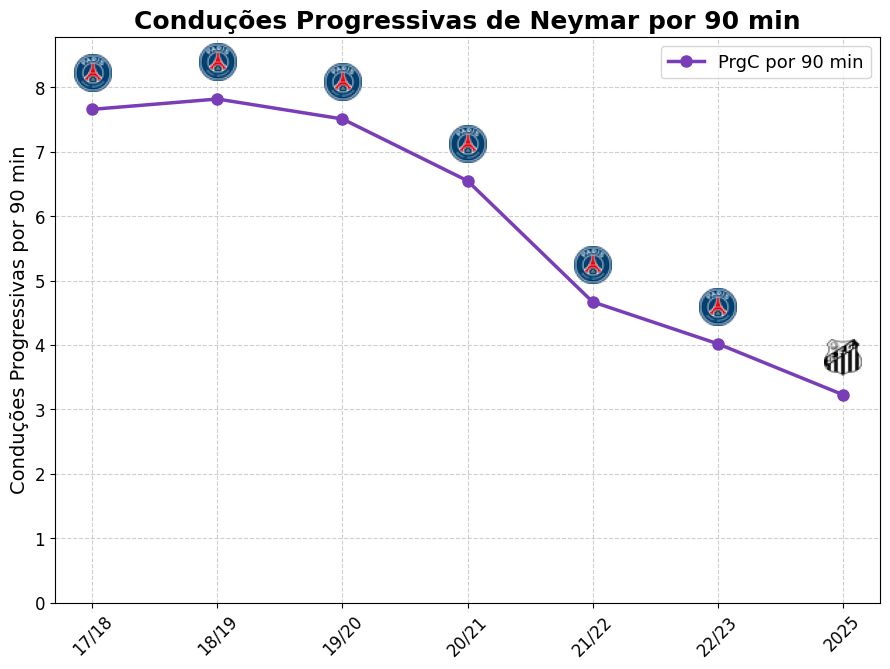

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

# x = índices (mantemos sua lógica visual), y = PG
x = np.arange(len(df))
y = df["PrgC_per90"].to_numpy()

plt.figure(figsize=(9,7))

# ===== Linha principal (roxo menos saturado) =====
plt.plot(
    x, y,
    marker="o",
    linewidth=2.5,
    markersize=8,
    label="PrgC por 90 min",
    color="#7A3DB8"
)

# ===== Logos (40x40) acima dos pontos =====
yr = np.ptp(y) if np.ptp(y) > 0 else 1.0
y_offset = 0.06 * yr   # ajuste fino (0.04–0.08)
ax = plt.gca()

for xi, (team, yi) in enumerate(zip(df["Time"], y)):
    path = logos_40.get(team)
    if path and os.path.exists(path):
        try:
            img = Image.open(path).convert("RGBA")  # já 40x40
            oi = OffsetImage(img, zoom=1.0)
            ab = AnnotationBbox(
                oi, (xi, yi + y_offset),
                frameon=False,
                box_alignment=(0.5, 0),
                xycoords="data"
            )
            ax.add_artist(ab)
        except Exception:
            plt.text(xi, yi + y_offset, team, ha="center", va="bottom", fontsize=10)
    else:
        plt.text(xi, yi + y_offset, team, ha="center", va="bottom", fontsize=10)

# ===== Estética =====
plt.title("Conduções Progressivas de Neymar por 90 min", fontsize=18, weight="bold")

plt.ylabel("Conduções Progressivas por 90 min", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=13)
plt.xticks(x, df["Ano"].tolist(), fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()

# Margem superior para caber os escudos
ymin = 0  # eixo y sempre começa em 0
ymax = float(y.max()) + y_offset + 0.15 * yr
ax.set_ylim(ymin, ymax)

plt.show()


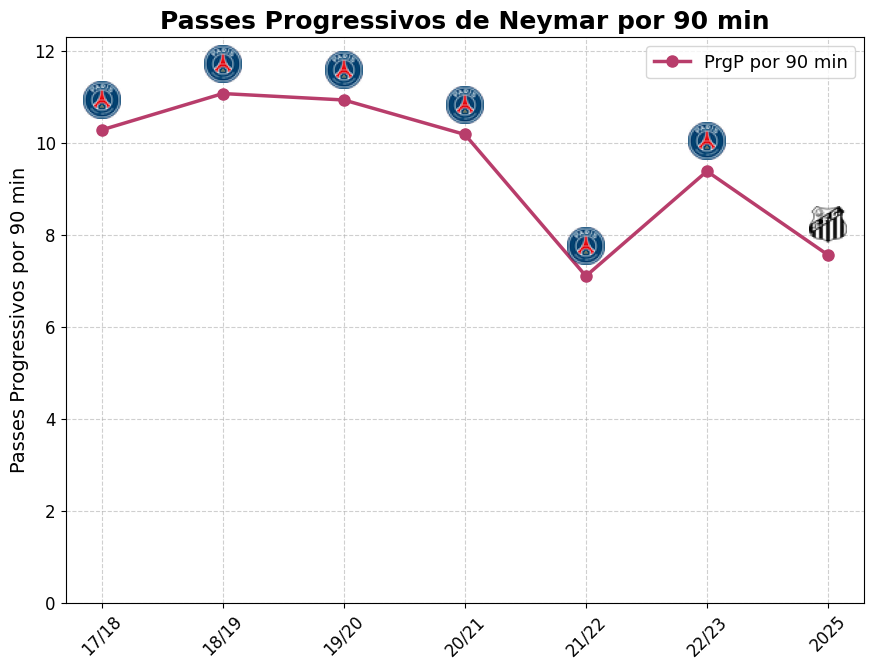

In [13]:
# x = índices (mantemos sua lógica visual), y = PG
x = np.arange(len(df))
y = df["PrgP_per90"].to_numpy()

plt.figure(figsize=(9,7))

# ===== Linha principal (roxo menos saturado) =====
plt.plot(
    x, y,
    marker="o",
    linewidth=2.5,
    markersize=8,
    label="PrgP por 90 min",
    color="#B83D6B"
)

# ===== Logos (40x40) acima dos pontos =====
yr = np.ptp(y) if np.ptp(y) > 0 else 1.0
y_offset = 0.06 * yr   # ajuste fino (0.04–0.08)
ax = plt.gca()

for xi, (team, yi) in enumerate(zip(df["Time"], y)):
    path = logos_40.get(team)
    if path and os.path.exists(path):
        try:
            img = Image.open(path).convert("RGBA")  # já 40x40
            oi = OffsetImage(img, zoom=1.0)
            ab = AnnotationBbox(
                oi, (xi, yi + y_offset),
                frameon=False,
                box_alignment=(0.5, 0),
                xycoords="data"
            )
            ax.add_artist(ab)
        except Exception:
            plt.text(xi, yi + y_offset, team, ha="center", va="bottom", fontsize=10)
    else:
        plt.text(xi, yi + y_offset, team, ha="center", va="bottom", fontsize=10)

# ===== Estética =====
plt.title("Passes Progressivos de Neymar por 90 min", fontsize=18, weight="bold")

plt.ylabel("Passes Progressivos por 90 min", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=13)
plt.xticks(x, df["Ano"].tolist(), fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()

# Margem superior para caber os escudos
ymin = 0  # eixo y sempre começa em 0
ymax = float(y.max()) + y_offset + 0.25 * yr
ax.set_ylim(ymin, ymax)

plt.show()


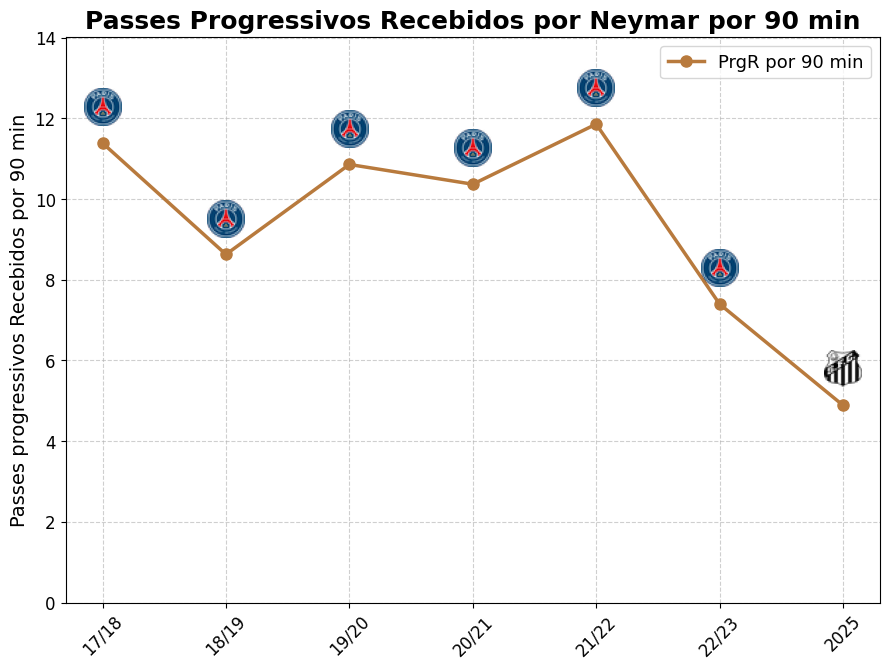

In [17]:
# x = índices (mantemos sua lógica visual), y = PG
x = np.arange(len(df))
y = df["prgR_per90"].to_numpy()

plt.figure(figsize=(9,7))

# ===== Linha principal (roxo menos saturado) =====
plt.plot(
    x, y,
    marker="o",
    linewidth=2.5,
    markersize=8,
    label="PrgR por 90 min",
    color="#B87A3D"
)

# ===== Logos (40x40) acima dos pontos =====
yr = np.ptp(y) if np.ptp(y) > 0 else 1.0
y_offset = 0.06 * yr   # ajuste fino (0.04–0.08)
ax = plt.gca()

for xi, (team, yi) in enumerate(zip(df["Time"], y)):
    path = logos_40.get(team)
    if path and os.path.exists(path):
        try:
            img = Image.open(path).convert("RGBA")  # já 40x40
            oi = OffsetImage(img, zoom=1.0)
            ab = AnnotationBbox(
                oi, (xi, yi + y_offset),
                frameon=False,
                box_alignment=(0.5, 0),
                xycoords="data"
            )
            ax.add_artist(ab)
        except Exception:
            plt.text(xi, yi + y_offset, team, ha="center", va="bottom", fontsize=10)
    else:
        plt.text(xi, yi + y_offset, team, ha="center", va="bottom", fontsize=10)

# ===== Estética =====
plt.title("Passes Progressivos Recebidos por Neymar por 90 min", fontsize=18, weight="bold")

plt.ylabel("Passes progressivos Recebidos por 90 min", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=13)
plt.xticks(x, df["Ano"].tolist(), fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()

# Margem superior para caber os escudos
ymin = 0  # eixo y sempre começa em 0
ymax = float(y.max()) + y_offset + 0.25 * yr
ax.set_ylim(ymin, ymax)

plt.show()


In [20]:
data_neymar.columns

Index(['Ano', 'Time', 'Min', 'PrgC', 'PrgP', 'PrgR', 'PrgC_per90',
       'PrgP_per90', 'prgR_per90', 'xG', 'xAG'],
      dtype='object')

In [21]:
data_players.columns

Index(['Player', 'Ano', 'Time', 'Min', 'PrgC', 'PrgP', 'PrgR', 'PRGC_per90',
       'PrgP_per90', 'PRGR_per90'],
      dtype='object')

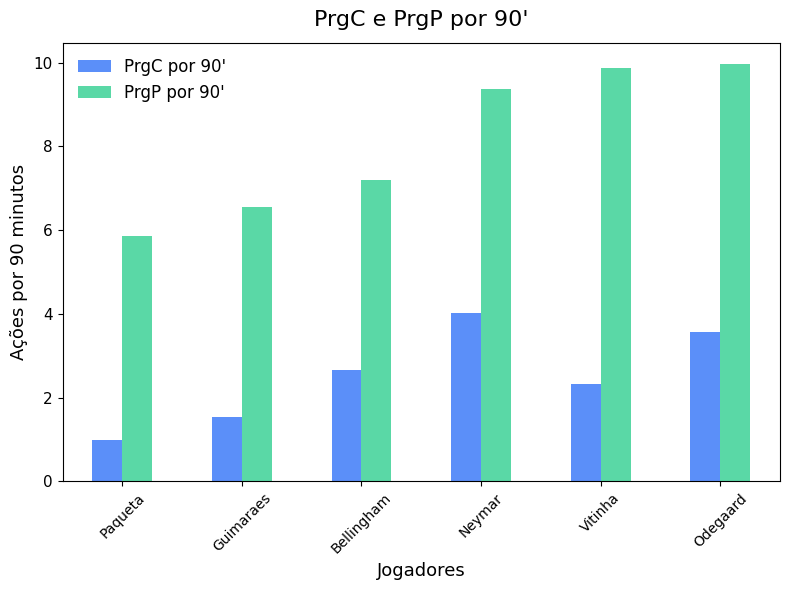

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Cópias e padronização
data_neymar = data_neymar.copy()
data_players = data_players.copy()
data_neymar.columns = data_neymar.columns.str.lower()
data_players.columns = data_players.columns.str.lower()

# Garantir coluna 'player' no Neymar
data_neymar['player'] = 'Neymar'

# Filtrar Neymar em 2025 (fallback: registro mais recente)
neymar_2025 = data_neymar[data_neymar['ano'] == 2025].copy()
if neymar_2025.empty:
    neymar_2025 = data_neymar.sort_values('ano').tail(1).copy()

# Selecionar colunas
cols = ['player', 'prgc_per90', 'prgp_per90']
df_plot = pd.concat([data_players[cols], neymar_2025[cols]])

# Remover Doku
df_plot = df_plot[~df_plot['player'].str.contains('doku', case=False, na=False)]

# Ordenar por PrgP/90 do menor para o maior
df_plot = df_plot.sort_values('prgp_per90', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
colors = ['#5B8FF9', '#5AD8A6']  # azul suave / verde suave
df_plot.set_index('player')[['prgc_per90', 'prgp_per90']].plot(
    kind='bar',
    ax=ax,
    color=colors,
    edgecolor='none'
)

# Título, eixos e rótulos maiores
ax.set_title("PrgC e PrgP por 90'", fontsize=16, pad=12)
ax.set_ylabel("Ações por 90 minutos", fontsize=13)
ax.set_xlabel("Jogadores", fontsize=13)
ax.tick_params(axis='x', labelrotation=45, labelsize=10)
ax.tick_params(axis='y', labelsize=11)

# Legenda renomeada
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["PrgC por 90'", "PrgP por 90'"], fontsize=12, frameon=False)

plt.tight_layout()
plt.show()
